In [28]:
import requests
import pandas as pd

# Define the GitHub user
user = "ursa-mikail"

# GitHub API endpoint for user's repositories
repos_url = f"https://api.github.com/users/{user}/repos"

# Fetch all repositories
response = requests.get(repos_url)
repos_data = response.json()

# Initialize list to hold commit data
all_commits_data = []

# Loop through each repository
for repo in repos_data:
    repo_name = repo['name']
    print(f"Fetching commits for repository: {repo_name}")

    # GitHub API endpoint for commits in the repository
    commits_url = f"https://api.github.com/repos/{user}/{repo_name}/commits"

    page = 1
    while True:
        response = requests.get(commits_url, params={'per_page': 100, 'page': page})

        # Check if the response status code indicates an error
        if response.status_code != 200:
            print(f"Error fetching commits for repository: {repo_name}, page: {page}, status code: {response.status_code}")
            break

        response_data = response.json()

        # Check if the response contains an error message
        if isinstance(response_data, dict) and 'message' in response_data:
            print(f"Error message: {response_data['message']}")
            break

        # Break the loop if no more commits are returned
        if len(response_data) == 0:
            break

        # Process the response data
        for commit in response_data:
            try:
                commit_date = commit['commit']['author']['date'][:10]  # Get the date (YYYY-MM-DD)
                all_commits_data.append({'date': commit_date, 'repo': repo_name})
            except KeyError as e:
                print(f"KeyError: {e} in repo: {repo_name}, commit: {commit}")

        # Go to the next page
        page += 1

# Convert list to DataFrame
df = pd.DataFrame(all_commits_data)

# Group by date and count commits per day
commit_counts = df.groupby(['date', 'repo']).size().reset_index(name='commits')

# Save to CSV
file_git_commits_csv = './sample_data/git_commits.csv'
commit_counts.to_csv(file_git_commits_csv, index=False)

print("CSV file 'git_commits.csv' created successfully.")


TypeError: string indices must be integers

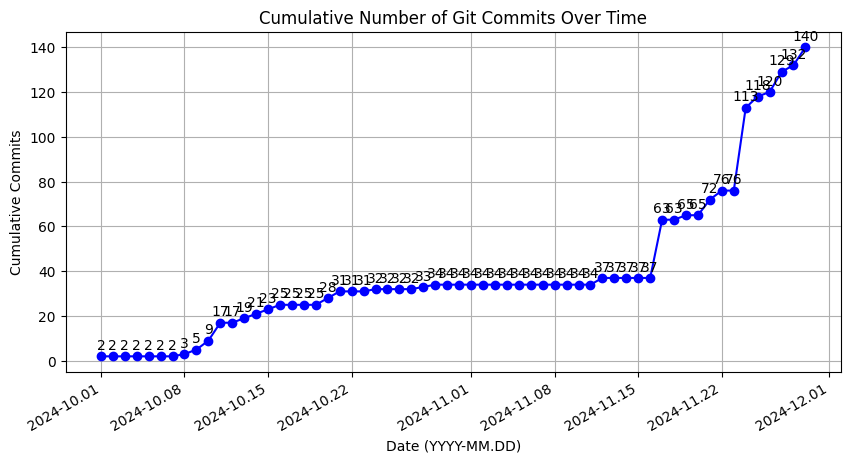

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv(file_git_commits_csv)

# Convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

# Group by date and sum the commits
df_grouped = df.groupby('date').sum().reset_index()

# Create a date range from the start to the end date in the data
date_range = pd.date_range(start=df_grouped['date'].min(), end=df_grouped['date'].max())

# Reindex the DataFrame to include all dates in the range and fill missing dates with 0 commits
df_grouped = df_grouped.set_index('date').reindex(date_range, fill_value=0).rename_axis('date').reset_index()

# Calculate cumulative commits for annotation
df_grouped['cumulative_commits'] = df_grouped['commits'].cumsum()

# Plot 1: Cumulative Commits Over Time
plt.figure(figsize=(10, 5))
plt.plot(df_grouped['date'], df_grouped['cumulative_commits'], marker='o', linestyle='-', color='b')
plt.xlabel('Date (YYYY-MM.DD)')
plt.ylabel('Cumulative Commits')
plt.title('Cumulative Number of Git Commits Over Time')
plt.grid(True)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m.%d'))
plt.gcf().autofmt_xdate()  # Rotate date labels for better readability

# Annotate the points with the cumulative number of commits
for i, row in df_grouped.iterrows():
    plt.annotate(row['cumulative_commits'], (row['date'], row['cumulative_commits']), textcoords="offset points", xytext=(0,5), ha='center')

# Show the first plot
plt.show()

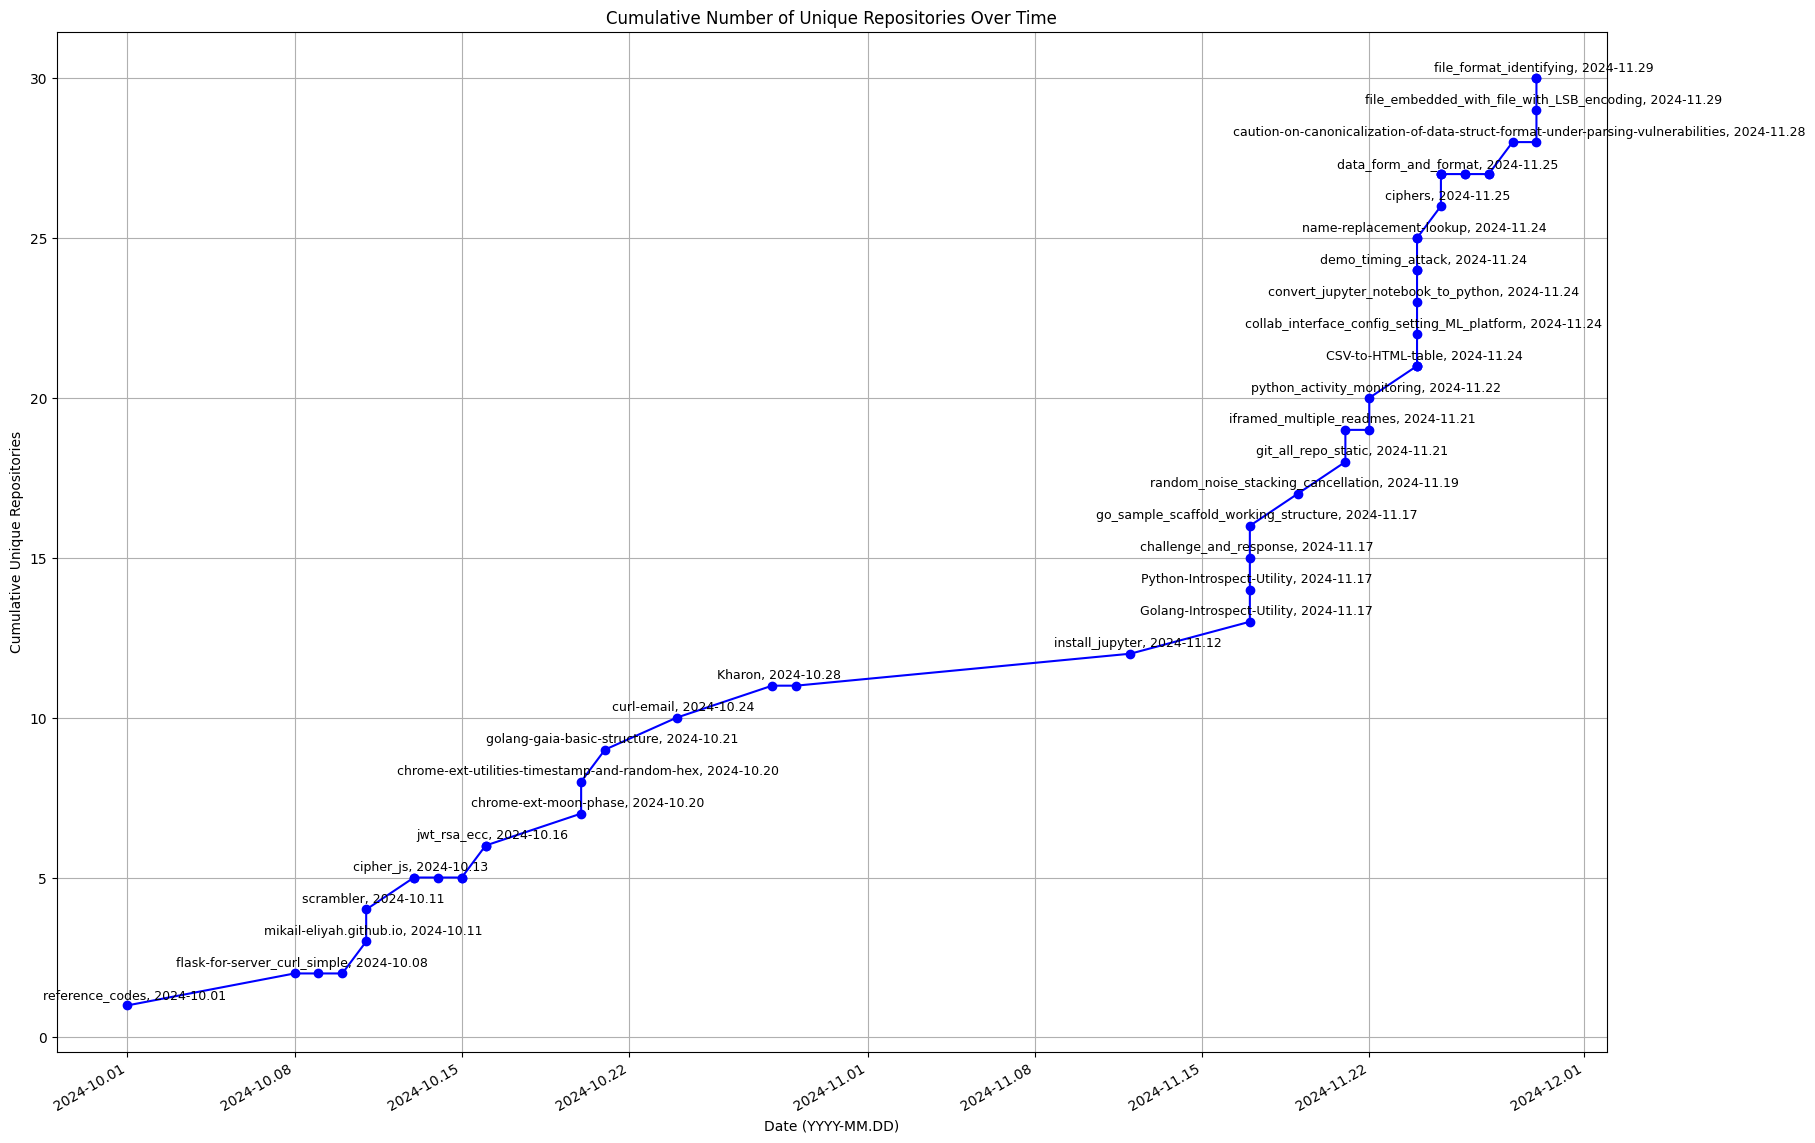

In [30]:
# Keep track of unique repositories and their first check-in dates
repo_checkins = {}  # Dictionary to store the first check-in date for each repo

# List to accumulate the cumulative repo counts
repo_cumulative = []

# Loop through the dataframe and calculate the cumulative unique repo count
cumulative_repos = 0
for idx, row in df.iterrows():
    repo = row['repo']
    if repo not in repo_checkins:
        # First check-in for this repo
        repo_checkins[repo] = row['date']
        cumulative_repos += 1  # Increment the cumulative repo count
    repo_cumulative.append(cumulative_repos)

df['cumulative_repos'] = repo_cumulative  # Add the cumulative repos column to the dataframe


# Plot 2: Plot First Check-ins and Connect them with a Line
plt.figure(figsize=(20, 15))
plt.plot(df['date'], df['cumulative_repos'], marker='o', linestyle='-', color='b')
plt.xlabel('Date (YYYY-MM.DD)')
plt.ylabel('Cumulative Unique Repositories')
plt.title('Cumulative Number of Unique Repositories Over Time')
plt.grid(True)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m.%d'))
plt.gcf().autofmt_xdate()  # Rotate date labels for better readability

# Annotate the points with the number of unique repos
for idx, row in df.iterrows():
    # Annotate only the first appearance of each repo
    if row['repo'] in repo_checkins and row['date'] == repo_checkins[row['repo']]:
        plt.annotate(f"{row['repo']}, {row['date'].strftime('%Y-%m.%d')}",
                     (row['date'], row['cumulative_repos']),
                     textcoords="offset points", xytext=(5, 5), ha='center', fontsize=9)

# Show the first plot
plt.show()

Total unique repositories: 30


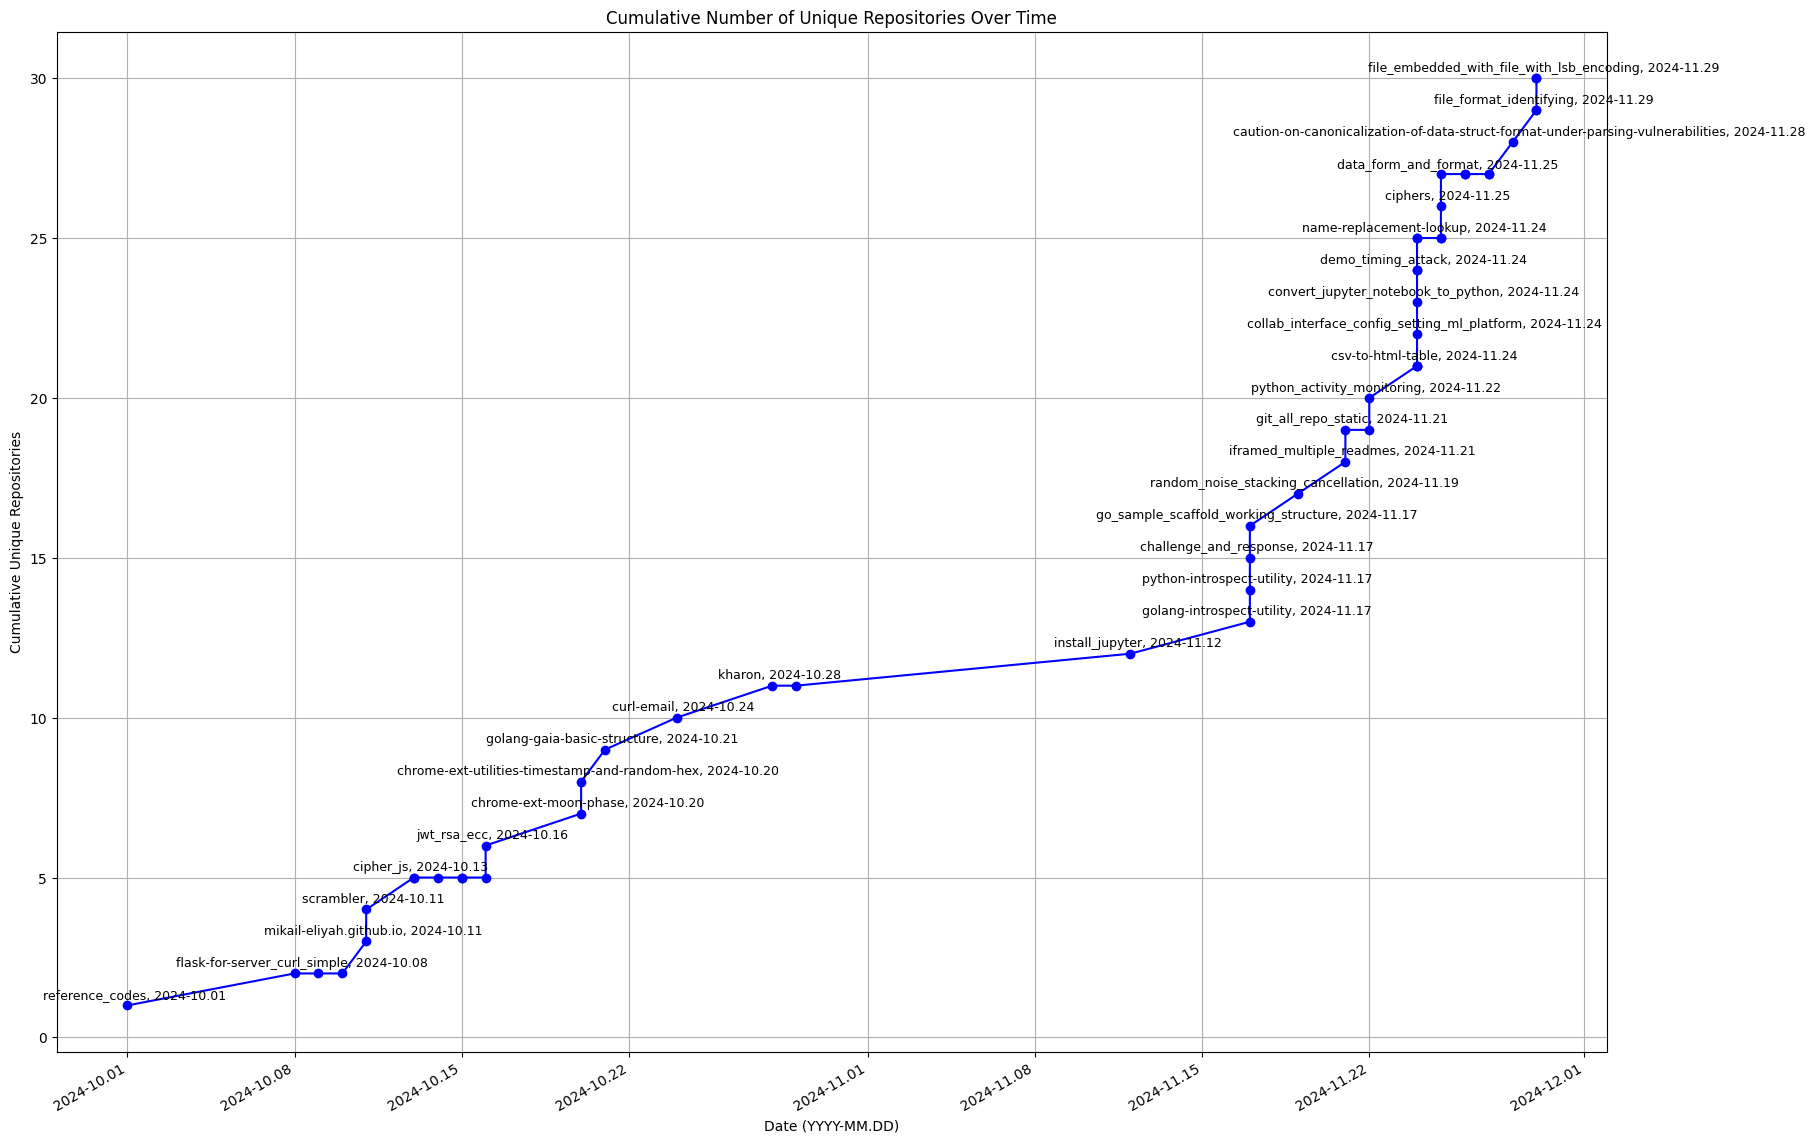

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv(file_git_commits_csv)

# Convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

# Clean repository names (standardize case and remove extra spaces)
df['repo'] = df['repo'].str.strip().str.lower()

# Sort by date to ensure that repos are processed in the correct order
df = df.sort_values(by='date')

# Remove duplicates to avoid counting the same repository on the same date
df = df.drop_duplicates(subset=['repo', 'date'])

# Keep track of unique repositories and their first check-in dates
repo_checkins = {}  # Dictionary to store the first check-in date for each repo

# List to accumulate the cumulative repo counts
repo_cumulative = []

# Loop through the dataframe and calculate the cumulative unique repo count
cumulative_repos = 0
for idx, row in df.iterrows():
    repo = row['repo']
    if repo not in repo_checkins:
        # First check-in for this repo
        repo_checkins[repo] = row['date']
        cumulative_repos += 1  # Increment the cumulative repo count
    repo_cumulative.append(cumulative_repos)

# Add the cumulative repo count to the dataframe
df['cumulative_repos'] = repo_cumulative

# Print the number of unique repositories to check the count
print(f"Total unique repositories: {df['repo'].nunique()}")

# Plot: Cumulative Unique Repositories Over Time
plt.figure(figsize=(20, 15))
plt.plot(df['date'], df['cumulative_repos'], marker='o', linestyle='-', color='b')
plt.xlabel('Date (YYYY-MM.DD)')
plt.ylabel('Cumulative Unique Repositories')
plt.title('Cumulative Number of Unique Repositories Over Time')
plt.grid(True)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m.%d'))
plt.gcf().autofmt_xdate()  # Rotate date labels for better readability

# Annotate the points with the first appearance of each repo
for idx, row in df.iterrows():
    if row['repo'] in repo_checkins and row['date'] == repo_checkins[row['repo']]:
        plt.annotate(f"{row['repo']}, {row['date'].strftime('%Y-%m.%d')}",
                     (row['date'], row['cumulative_repos']),
                     textcoords="offset points", xytext=(5, 5), ha='center', fontsize=9)

# Show the plot
plt.show()
